# Combination of Computer Vision Detection adn Segmentation for Autonomous Driving
mail: gsn915315@gmail.com

In [17]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from keras_ssd7 import build_model
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

# Basic Parameters setting


In [18]:
img_height = 256 # Height of the input images
img_width = 256 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 3 # Number of classes including the background class
min_scale = 0.08 # The scaling factor for the smallest anchor boxes
max_scale = 0.96 # The scaling factor for the largest anchor boxes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False # Whether or not the model is supposed to use relative coordinates that are within [0,1]

# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model, predictor_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                     n_classes=n_classes,
                                     min_scale=min_scale,
                                     max_scale=max_scale,
                                     scales=scales,
                                     aspect_ratios_global=aspect_ratios,
                                     aspect_ratios_per_layer=None,
                                     two_boxes_for_ar1=two_boxes_for_ar1,
                                     limit_boxes=limit_boxes,
                                     variances=variances,
                                     coords=coords,
                                     normalize_coords=normalize_coords,
                                     train_normal=False)

# 2: Optional: Load some weights
model.load_weights('./fcn_weights.h5', by_name=True)
model.load_weights('./ssd7_test_fine_tune_weights.h5', by_name=True)

# 1: Instantiate to `BatchGenerator` objects: One for training, one for validation.

train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])
val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

# Dataset path

In [5]:
# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your datasets here.

# Validation dataset
val_images_path = '/home/yuho/Desktop/screenshot/crop_image/crop_detection/detection_image/'
val_labels_path = '/home/yuho/Desktop/screenshot/crop_image/crop_detection/train_labels.csv'

val_dataset.parse_csv(images_path=val_images_path,
                      labels_path=val_labels_path,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

In [6]:
# 3: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function. 

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 4: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into memory issues with your GPU.

# 5: Set the image processing / data augmentation options and create generator handles.

# Change the online data augmentation settings as you like

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=True,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=False,
                                     full_crop_and_resize=False,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4,
                                     diagnostics=False)

# Get the number of samples in the validations datasets to compute the epoch lengths below.
n_val_samples = val_dataset.get_n_samples()

In [12]:
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         train=False,
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=False,
                                         full_crop_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

# Show ground Truth

In [61]:
X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

Image: /home/yuho/Desktop/screenshot/crop_image/crop_detection/detection_image/202.png

Ground truth boxes:

[[  2  89 115  66  81]
 [  2 115 143  62  72]
 [  2 240 256  61  71]]


# Prediction from our model [class_id, confidence, xmin, xmax, ymin, ymax]

In [62]:
y_pred = model.predict(X)

y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.8,
                           iou_threshold=0.1,
                           top_k='all',
                           input_coords='centroids',
                           normalize_coords=False,
                           img_height=None,
                           img_width=None)

print("Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):\n")
print(y_pred_decoded[i])

Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):

[[   2.            0.99999964   90.06874847  113.34650421   65.84074402
    81.15357971]
 [   2.            0.99992001  114.38027191  143.83721924   61.36399841
    71.46264648]
 [   2.            0.94952136  237.20217896  255.72497559   60.47091675
    70.38897705]]


# Show image
green: ground truth
blue: prediction

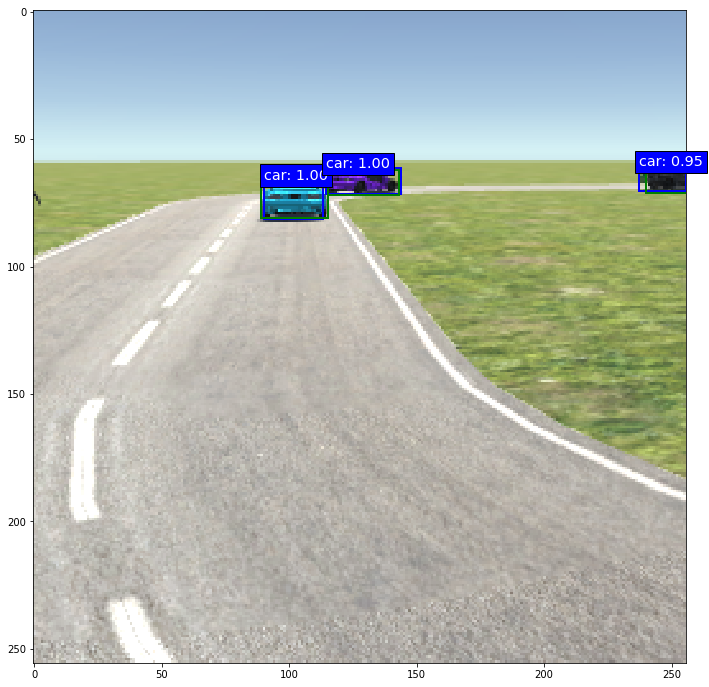

In [63]:
plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

classes = ['background', 'people', 'car'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
    current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_true[i]:
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((box[1], box[3]), box[2]-box[1], box[4]-box[3], color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

### 5. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator which we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [3]:
import scipy.misc
def print_segmentation_onto_image(image, prediction, color_map):
    '''
    Prints a segmentation onto an equally-sized image according to a color map.

    Arguments:
        image (array-like): A 3-channel image onto which to print the segmentation
            from `prediction`.
        prediction (array-like): A rank-4 array that is the segmentation prediction
            with the same spatial dimensions as `image`. The last axis contains the
            segmentation classes in one-hot format.
        color_map (dictionary): A Python dictionary whose keys are non-negative
            integers representing segmentation classes and whose values are 1D tuples
            (or lists, Numpy arrays) of length 4 that represent the RGBA color values
            in which the respective classes are to be annotated. For example, if the
            dictionary contains the key-value pair `{1: (0, 255, 0, 127)}`, then
            this means that all pixels in the prediction that belong to segmentation
            class 1 will be colored in green with 50% transparency in the input image.

    Returns:
        A copy of the input image with the segmentation printed onto it.

    Raises:
        ValueError if the spatial dimensions of `image` and `prediction` don't match.
    '''

    if (image.shape[0] != prediction.shape[1]) or (image.shape[1] != prediction.shape[2]):
        raise ValueError("'image' and 'prediction' must have the same height and width, but image has spatial dimensions ({}, {}) and prediction has spatial dimensions ({}, {}).".format(image.shape[0], image.shape[1], prediction.shape[1], prediction.shape[2]))

    image_size = image.shape

    # Create a template of shape `(image_height, image_width, 4)` to store RGBA values.
    mask_place = np.zeros(shape=(image_size[0], image_size[1]),  dtype=np.int)
    mask = np.zeros(shape=(image_size[0], image_size[1], 4), dtype=np.uint8)
    segmentation_map = np.squeeze(np.argmax(prediction, axis=-1))

    # Loop over all segmentation classes that are to be annotated and put their
    # color value at the respective image pixel.
    for segmentation_class, color_value in color_map.items():
        mask_palce = np.where(segmentation_map==segmentation_class)
        mask[mask_palce] = color_value

    mask = scipy.misc.toimage(mask, mode="RGBA")

    output_image = scipy.misc.toimage(image)
    output_image.paste(mask, box=None, mask=mask) # See http://effbot.org/imagingbook/image.htm#tag-Image.Image.paste for details.

    return output_image

In [4]:
from collections import namedtuple

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [5]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'person'               ,  1 ,        1 , 'human'           , 1       , True         , False        , (255,  0, 0) ),
    Label(  'car'                  ,  2 ,        2 , 'vehicle'         , 2       , True         , False        , (  0, 255,0) ),
    Label(  'road'                 ,  3 ,        3 , 'flat'            , 3       , False        , False        , (255, 255,0) ),
]

LABELS = labels

TRAINIDS_TO_COLORS_DICT = {label.trainId: label.color for label in labels}

TRAINIDS_TO_RGBA_DICT = {key: (value[0], value[1], value[2], 127) for key, value in TRAINIDS_TO_COLORS_DICT.items()}

In [6]:
### Make predictions

# 1: Set the generator

# prediction_generator = val_dataset.generate(batch_size=1,
#                                          shuffle=False,
#                                          train=False,
#                                          equalize=False,
#                                          brightness=False,
#                                          flip=False,
#                                          translate=False,
#                                          scale=False,
#                                          max_crop_and_resize=False,
#                                          full_crop_and_resize=False,
#                                          random_crop=False,
#                                          crop=False,
#                                          resize=False,
#                                          gray=False,
# #                                          limit_boxes=True,
# #                                          include_thresh=0.4,
#                                          diagnostics=False)
from glob import glob
import os

image_dir = '/home/yuho/Desktop/screenshot/crop_image/crop_scene/'
image_paths = glob(os.path.join(image_dir, '*.png'))  # Get all images in this directory

print(len(image_paths))

411


# Original image

48.png


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


10.png
41.png


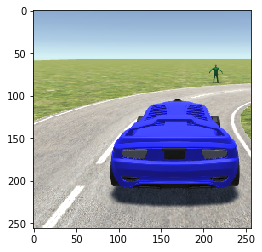

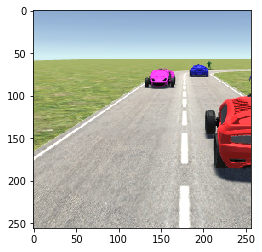

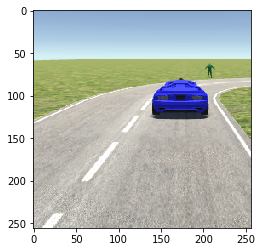

In [7]:
batch_size = 3
current = 0

for image_path in image_paths[current:current+batch_size]: # Careful: This works in Python, but might cause an 'index out of bounds' error in other languages if `current+batch_size > len(image_paths)`
    print(image_path[52:])
    
    # Load the image
    image = scipy.misc.imread(image_path)
    plt.figure()
    plt.imshow(image)

# Model Summary

In [89]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda1 (Lambda)                (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 32) 2432        lambda1[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 256, 256, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
elu1 (ELU)

# AP Detection Accuracy

In [85]:
import ssd_box_encode_decode_utils as uti

iou_threshold = 0.5
true_positive = []
num_true_positive = []

class_counter = 2 # class
counter = 1

num_image = 1

# image_dir = '/home/yuho/Desktop/screenshot/crop_image/crop_scene/'
# image_paths = glob(os.path.join(image_dir, '*.png'))  # Get all images in this directory
save_image_dir = '/home/yuho/Desktop/screenshot/crop_image/outputs/'

batch_size = len(image_paths)
# batch_size = 5
current = 0

for image_path in image_paths[:batch_size]: # Careful: This works in Python, but might cause an 'index out of bounds' error in other languages if `current+batch_size > len(image_paths)`

    X, y_true, filenames = next(prediction_generator)
    
    segmentation, y_pred = model.predict(X)

    y_pred_decoded = decode_y2(y_pred,
                               confidence_thresh=0.8,
                               iou_threshold=0.1,
                               top_k='all',
                               input_coords='centroids',
                               normalize_coords=False,
                               img_height=None,
                               img_width=None)
    pre = y_pred_decoded[0]
    gt = y_true[0]
    
    ### Visualize Debug ###
#     # Load the image
#     image = scipy.misc.imread(filenames[0])
    
#     #     X = np.expand_dims(image,0)
#     print("image_path: ", image_path)

#     plt.figure(figsize=(20,12))
#     plt.imshow(image)

#     current_axis = plt.gca()

#     classes = ['background', 'people', 'car'] # Just so we can print class names onto the image instead of IDs

#     safe_zone = 6
    
#     # Draw the predicted boxes in blue
#     for box in y_pred_decoded[0]:
#         label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     #     if label==1:
#         current_axis.add_patch(plt.Rectangle((box[2]-safe_zone/2, box[4]-safe_zone/2), box[3]-box[2]+safe_zone, box[5]-box[4]+safe_zone, color='blue', fill=False, linewidth=2))  
#         current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

#     safe_zone = 0

#     # Draw the ground truth boxes in green (omit the label for more clarity)
#     for box in gt:
#         label = '{}'.format(classes[int(box[0])])
#         current_axis.add_patch(plt.Rectangle((box[1]-safe_zone/2, box[3]-safe_zone/2), box[2]-box[1]+safe_zone, box[4]-box[3]+safe_zone, color='green', fill=False, linewidth=2))  
#         #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})
    ### Visualize Debug ###
#     print(pre)
#     print("pre:", pre[0])
#     print(gt[0])
    
    for i in range(len(pre)):  # prediction
        for j in range(len(gt)):  # ground true 
            iou = uti.iou(pre[i][2:], gt[j][1:])
            if (iou>=iou_threshold and pre[i][0]==class_counter and pre[i][0]==gt[j][0]):
                true_positive.append(1)
                num_true_positive.append(counter)
                counter = counter + 1
                break
            elif (j==len(gt)-1 and pre[i][0]==class_counter):
                true_positive.append(0)
                num_true_positive.append(counter-1)
            


np_true_positive = np.asarray(true_positive)
np_num_true_positive = np.asarray(num_true_positive)
precision = np.ones([len(true_positive)+1])
recall = np.zeros([len(true_positive)+1])

for i in range(len(true_positive)):
    precision[i+1] = np_num_true_positive[i]/(i+1.)
    
recall[1:] = np_num_true_positive/(len(true_positive)+0.)
    
# print("true_positive: ", true_positive)
# print("num_true_positive: ", num_true_positive)
# print("precision: ", precision[1:])
# print("recall: ", recall[1:])

# average precision
active_AP = np_true_positive*precision[1:]
AP = np.sum(active_AP)/np.sum(np_true_positive)
print("AP: ", AP)

# mean average precision
# formula: ( 1/num_class * (sum(different_class_ap))

AP:  0.993118335347


# Segmentation Accuracy

In [24]:
import numpy as np
import glob

# image_dir = '/home/yuho/Desktop/screenshot/crop_image/crop_scene/'
# image_paths = glob(os.path.join(image_dir, '*.png'))  # Get all images in this directory
image_seg_GT_dir = '/home/yuho/Desktop/screenshot/crop_image/crop_GT_number/'

batch_size = len(image_paths)
# batch_size = 5
current = 0

save_true_pos = []
save_false_pos = []
save_false_neg = []

for image_path in image_paths[current:current+batch_size]: # Careful: This works in Python, but might cause an 'index out of bounds' error in other languages if `current+batch_size > len(image_paths)`
    
    name = image_path[len(image_dir):]
#     print(name)
    
    # Load the image
    image = scipy.misc.imread(image_path)
    image_GT = scipy.misc.imread(image_seg_GT_dir+name)
    
#     print(image_path)
#     print(image_seg_GT_dir+name)
    
    X = np.expand_dims(image,0)
  
    segmentation, y_pred = model.predict(X)

    pre = segmentation[0]
    gt = image_GT

    road_class = 3

    gt = np.squeeze(gt)
    pred = np.squeeze(np.argmax(pre, axis=-1))
    
#     print(gt)
#     print(pred)
    
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            if ((pred[i][j]==gt[i][j] and pred[i][j]==road_class)): # or (pred[i][j]!=road_class and gt[i][j]!=road_class)):
                true_pos = true_pos + 1
            elif (pred[i][j]!=gt[i][j] and pred[i][j]==road_class):
                false_pos = false_pos +1
            elif (pred[i][j]!=gt[i][j] and gt[i][j]==road_class):
                false_neg = false_neg+1
    
    save_true_pos.append(true_pos)
    save_false_pos.append(false_pos)
    save_false_neg.append(false_neg)
            
seg_acc = np.sum(np.asarray(save_true_pos))/(np.sum(np.asarray(save_true_pos))+np.sum(np.asarray(save_false_pos+save_false_neg))+0.)
# print("true_pos: ", save_true_pos)
# print("false_pos: ", save_false_pos)
# print("false_neg: ", save_false_neg)
print("segmentation accuracy: ", seg_acc)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


true_pos:  [26251, 34749, 37792, 38543, 33366, 10351, 9851, 38043, 25175, 38331, 26437, 705, 38371, 40777, 613, 34354, 36567, 38849, 34505, 37726, 38280, 26161, 40880, 34230, 38219, 19362, 34688, 37852, 27244, 34151, 41240, 35389, 29377, 34871, 40480, 36310, 41276, 40331, 29363, 34106, 23087, 37971, 1531, 24335, 27239, 35000, 8325, 40013, 39192, 12697, 35321, 34108, 22287, 38055, 37563, 34036, 0, 39816, 33079, 37452, 35617, 35217, 37109, 37702, 38692, 40597, 39343, 40612, 36752, 35453, 480, 37937, 28714, 32395, 29290, 36167, 37007, 28885, 39411, 35710, 37504, 37380, 27633, 36674, 40979, 1192, 28275, 26757, 38599, 37738, 27319, 36981, 36591, 33754, 32618, 36202, 17997, 34074, 38292, 23035, 36248, 37984, 22695, 36617, 37424, 37271, 34121, 38063, 38419, 32650, 20933, 33078, 39694, 34527, 41249, 38387, 20622, 37702, 32196, 38096, 37498, 38582, 31550, 33639, 36776, 37387, 41269, 39095, 27260, 28608, 38918, 36961, 36832, 34181, 37762, 33001, 32403, 34821, 741, 39976, 31880, 11930, 39374, 368

# Prediction

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


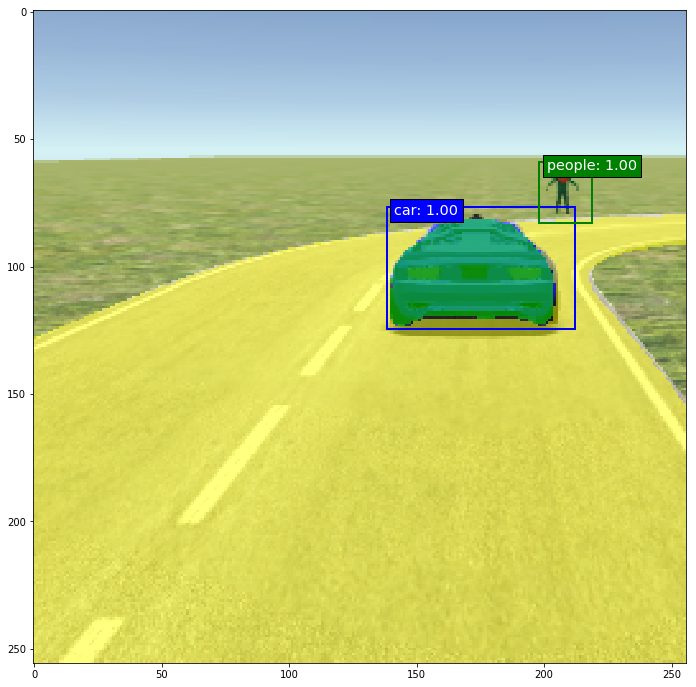

In [12]:
# 5: Draw the predicted boxes onto the image

segmented_image = print_segmentation_onto_image(X[0], segmentation, color_map=TRAINIDS_TO_RGBA_DICT)

plt.figure(figsize=(20,12))
plt.imshow(segmented_image)

current_axis = plt.gca()

classes = ['background', 'people', 'car'] # Just so we can print class names onto the image instead of IDs

safe_zone = 6

color_box = 'blue'

# Draw the predicted boxes in blue
for box in y_pred_decoded[0]:
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    class_num = int(box[0])
    if class_num==1:
        color_box = 'green'
    elif class_num==2:
        color_box = 'blue'
    current_axis.add_patch(plt.Rectangle((box[2]-safe_zone/2, box[4]-safe_zone/2), box[3]-box[2]+safe_zone, box[5]-box[4]+safe_zone, color=color_box, fill=False, linewidth=2))  
    current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':color_box, 'alpha':1.0})

# safe_zone = 0
    
# # Draw the ground truth boxes in green (omit the label for more clarity)
# for box in y_true[i]:
#     label = '{}'.format(classes[int(box[0])])
#     current_axis.add_patch(plt.Rectangle((box[1]-safe_zone/2, box[3]-safe_zone/2), box[2]-box[1]+safe_zone, box[4]-box[3]+safe_zone, color='green', fill=False, linewidth=2))  
#     #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})
    
plt.savefig('/home/yuho/Desktop/1.png')


# Activation

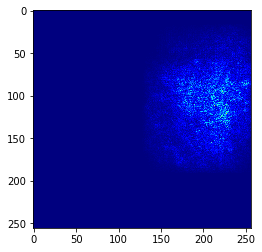

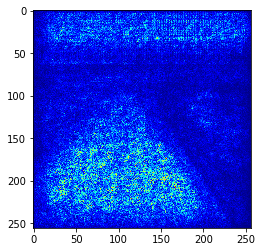

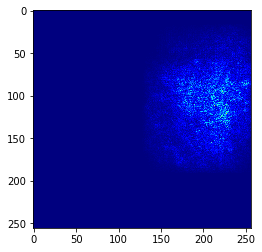

In [64]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

img = X[0]
class_idx = 1 # car

for i, name in enumerate(['classes_softmax', 'boxes_concat', 'predictions']):
    
    plt.figure()
    
    # Utility to search for layer index by name. 
    # Alternatively we can specify this as -1 since it corresponds to the last layer.
    layer_idx = utils.find_layer_idx(model, name)

    # Swap softmax with linear
    model.layers[layer_idx].activation = activations.linear

    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=img)
    # Plot with 'jet' colormap to visualize as a heatmap.
    plt.imshow(grads, cmap='jet')

# Main Reference: https://github.com/pierluigiferrari/ssd_keras